In [1]:
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from ic_course_utils import replace_tag
from ic_course_utils import find_pmap_with_s1_s2
from ic_course_utils import create_hits_animation

%matplotlib inline

In [2]:
input_file = "data/HEe_fullsim.irene.h5"
#input_file = "data/HEe_fastsim.irene.h5"
#input_file = "data/HEe_fullsim.hypathia.h5"
#input_file = "data/HEe_fastsim.hypathia.h5"

# Input file structure

The input file contains five nodes under the group `/PMAPS/`:
- `/PMAPS/S1`: holds the PMT-summed waveform slices of S1 signals
- `/PMAPS/S1Pmt`: holds the individual PMT waveform slices of S1 signals
- `/PMAPS/S2`: holds the PMT-summed waveform slices of S2 signals
- `/PMAPS/S2Pmt`: holds the individual PMT waveform slices of S2 signals
- `/PMAPS/S2Si`: holds the individual SiPM waveform slices of S2 signals

These are tables with the following columns.
- For `S1`and `S2`: event, peak number, waveform time, bin width and amplitude (of the PMT-summed waveform)
- For `S1Pmt`and `S2Pmt` and `S2Sipm`: event, peak number, sensor id and amplitude (of the individual sensor waveform)

`/PMAPS/S1Pmt` and `/PMAPS/S2Pmt` are not used in the default reconstruction chain.

In [3]:
!ptdump -v $input_file:/PMAPS

/PMAPS (Group) ''
/PMAPS/S1 (Table(154,)shuffle, zlib(4)) 'S1 Table'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "peak": UInt8Col(shape=(), dflt=0, pos=1),
  "time": Float32Col(shape=(), dflt=0.0, pos=2),
  "bwidth": Float32Col(shape=(), dflt=0.0, pos=3),
  "ene": Float32Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (3120,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumshuffle, zlib(1)).is_csi=False}
/PMAPS/S1Pmt (Table(1848,)shuffle, zlib(4)) 'S1Pmt Table'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "peak": UInt8Col(shape=(), dflt=0, pos=1),
  "npmt": UInt8Col(shape=(), dflt=0, pos=2),
  "ene": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (4681,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumshuffle, zlib(1)).is_csi=False}
/PMAPS/S2 (Table(1014,)shuffle, zlib(4)) 'S2 Table'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "

# Input file data visualization

PMaps have a friendly human interface in IC.
The `Pmap` class is a collection of S1 and S2 `Peak`s:
```
pmap.s1s = [s1_signal_1, s1_signal_2, ...]
pmap.s2s = [s2_signal_1, s2_signal_2, ...]
```
Each `Peak` aggregates 3 objects:
- times: an array of the times corresponding to each waveform sample
- pmts: a SensorResponse object containing the PMT data
- sipms: a SensorResponse object containing the SiPM data

Each `SensorResponse` contains the following information:
- `ids`: the id numbers of the sensors stored in this object
- `all_waveforms`: the waveform slices corresponding to the `times` stored in `Peak`

`Peak` and `SensorResponse` contain several attributes and methods that implement the most common operations on PMaps.

PMaps can be also read as pandas DataFrames.

In [4]:
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df

pmaps    = load_pmaps      (input_file)
pmaps_df = load_pmaps_as_df(input_file)

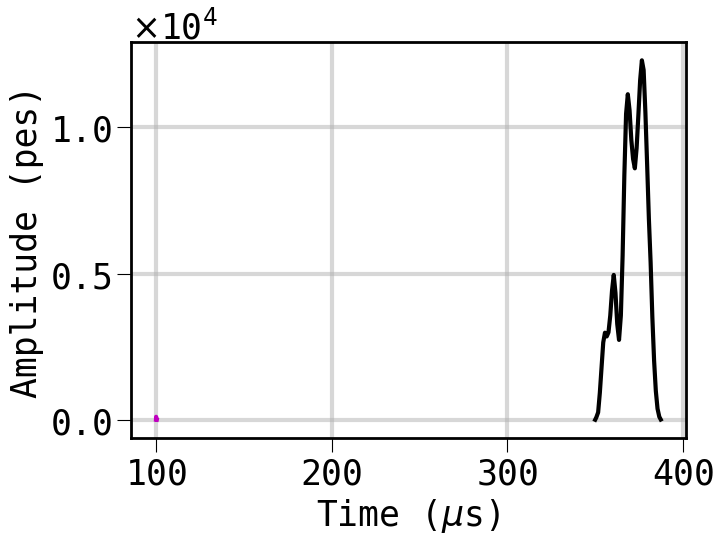

In [5]:
event_number, pmap = find_pmap_with_s1_s2(pmaps)
pmap = pmaps[event_number]
for s1 in pmap.s1s: # s1 is a `Peak`
    plt.plot(s1.times / 1e3, s1.pmts.sum_over_sensors, "m") # plot the PMT-summed waveform slice

for s2 in pmap.s2s: # s2 is a `Peak`
    plt.plot(s2.times / 1e3, s2.pmts.sum_over_sensors, "k") # plot the PMT-summed waveform slice
    
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)");

Some common operations on PMaps (explore the classes in https://github.com/next-exp/IC/blob/master/invisible_cities/evm/pmaps.py for more details):

In [6]:
s1 = pmap.s1s[0]
s2 = pmap.s2s[0]
print(f"The PMT integral of the S2 is {s2.total_energy:.1f} pes")
print(f"The SiPM integral of the S2 is {s2.total_charge:.1f} pes")
print(f"The width of the S2 is {s2.width/1e3:.1f} us")
print(f"The height of the S2 is {s2.height:.1f} pes")
print(f"The S1 of this event happened at {s1.time_at_max_energy/1e3:.2f} us")

The PMT integral of the S2 is 208740.8 pes
The SiPM integral of the S2 is 9913.1 pes
The width of the S2 is 37.6 us
The height of the S2 is 12289.2 pes
The S1 of this event happened at 100.10 us


The same can be achieved with DataFrames:

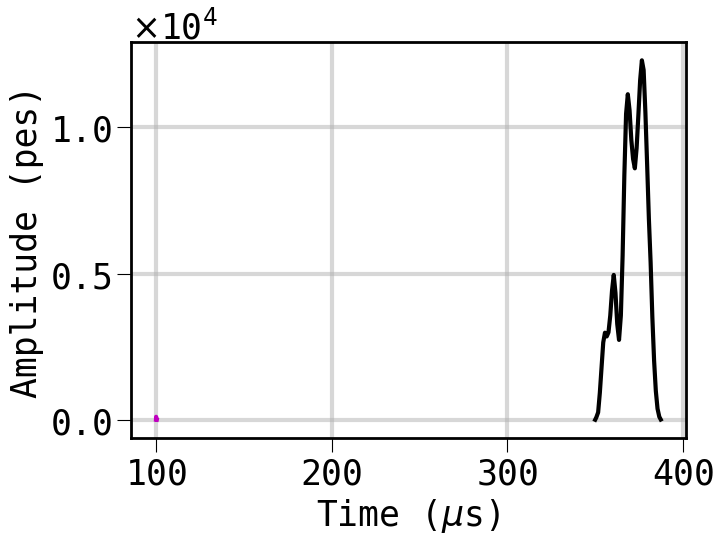

In [7]:
event_number, pmap = find_pmap_with_s1_s2(pmaps)
s1s, s2s, s2sis, s1pmts, s2pmts = pmaps_df
s1s   = s1s  .loc[lambda df: df.event == event_number]
s2s   = s2s  .loc[lambda df: df.event == event_number]
s2sis = s2sis.loc[lambda df: df.event == event_number]

for _, s1 in s1s.groupby("peak"):
    plt.plot(s1.time / 1e3, s1.ene, "m") # plot the PMT-summed waveform slice

for _, s2 in s2s.groupby("peak"):
    plt.plot(s2.time / 1e3, s2.ene, "k") # plot the PMT-summed waveform slice

plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)");

In [8]:
s1 = s1s  .loc[lambda df: df.peak == 0]
s2 = s2s  .loc[lambda df: df.peak == 0]
si = s2sis.loc[lambda df: df.peak == 0]

# need to add one bin for the total width!
dt = s2.time.max() - s2.time.min() + s2.bwidth.iloc[-1]

print(f"The PMT integral of the S2 is {s2.ene.sum():.1f} pes")
print(f"The SiPM integral of the S2 is {si.ene.sum():.1f} pes")
print(f"The width of the S2 is {dt/1e3:.1f} us")
print(f"The height of the S2 is {s2.ene.max():.1f} pes")
print(f"The S1 of this event happened at {s1.time.loc[s1.ene.idxmax()]/1e3:.2f} us")

The PMT integral of the S2 is 208740.8 pes
The SiPM integral of the S2 is 9913.1 pes
The width of the S2 is 37.8 us
The height of the S2 is 12289.2 pes
The S1 of this event happened at 100.10 us


# Sophronia

## Description

Creates 3D hits by associating position, time, energy and charge.

This city reads Peak Maps (a.k.a PMaps) produced by Irene or Hypathia and produces hDSTs (hit DSTs).
Each time slice in an S2 signal is processed to produce a collection of 3D points with associated charge and energy values.

Like in Dorothea, the city applies the following selection criteria on S1 and S2 peaks:
- Width
- Height
- Integral
- Number of SiPMs involved (S2 only)

These properties are measured based on thresholds applied to the PMT-summed waveform.
The event is then selected or discarded based on whether the number of selected S1 and S2 signals fall within the specified range.
This city needs to assume that exactly one S1 signal was measured (\*).
Surviving events are further processed to obtain hits.
First, the S2 signal is resampled to produce thicker slices.
For each slice in each S2 peak, the city creates a colleciton of hits, each corresponding to a SiPM. A hit contains the following information:
- X: X position of the SiPM)
- Y: Y position of the SiPM)
- Z: time difference between the S2 slice and the S1
- Q: SiPM charge in the slice
- E: corresponding fraction of the slice energy (PMT integral) calculated as $\frac{Q_i}{\sum Q_i}$ 
- 

In the special case where none of the SiPMs have enough charge to survive previous cuts, but there is an energy recording in the slice, a fake hit is created (a.k.a. NN-hits). This hit has special values for charge and position (\*\*) that allow special treatment further down the line.

After all hits are created, NN-hits are merged with other non-NN-hits. Their energy is shared among the closest hits.

Finally and optionally, geometrical and lifetime corrections are applied (\*\*\*).

(\*) If no S1s are recorded, it is not possible to reconstruct Z from the time difference between S1 and S2. If multiple S1s are detected, there is ambiguity in the value Z. The city allows the user to permit more than one *selected* S1 per event, but it will always use the first one to compute z.

(\*\*) These special values are equivalent to a NaN, but they are given a numerical value for historical reasons. The number used as a NaN equivalent is -999999.

(\*\*\*) There corrections can be applied both here and in Esmeralda. The reason for this duplicity is purely practical. This allows to obtain a corrected energy spectrum during data taking using a correction map from a previous run. The final corrections will always be applied in Esmeralda using a map from the same run.

More details will be found in the official documentation:
https://next-exp-sw.readthedocs.io/en/latest/sophronia.html
.

## Parameters

| Parameter | Type  | Description |
|:--------:|:--------:|:--------:|
| `drift_v` | `float | Estimated drift velocity |
| `s1_params` | `dict` | S1 selection parameters (see Dorothea for details) |
| `s2_params` | `dict` | S2 selection parameters (see Dorothea for details) |
| `global_reco_algo` | `XYReco` | Which algorithm to use for event reconstruction: barycenter (most commonly used) or corona |
| `global_reco_params` | `dict` | Parameters to configure the reconstruction algorithm |
| `rebin` | `int` | Resampling parameter. Its interpretation depends on `rebin_method` |
| `rebin_method` | `RebinMethod` | Resampling method for S2 slices: `stride` (most commonly used) or `threshold`.<br> `stride` accumulates `rebin` consecutive slices, while `threshold` accumulates slices until a minimum PMT charge `rebin` is achieved |
| `q_thr` | `float` | Charge threshold for hit creation |
| `sipm_charge_type` | `SiPMCharge` | How to treat SiPM signals: raw (most commonly used) or signal_to_noise |
| `same_peak` | `Optional[bool]` | Whether to allow the NN hits' energy reassignment to hits in other S2 peaks |
| `corrections_file` | `Optional[str]` | Filename containing the correction maps |
| `apply_temp` | `Optional[bool]` | Whether to apply temporal corrections (always False for MC) |

## Configuration

A typical Sophronia configuration file for NEW data.

Note that here we don't specify the input and output files in the config file, but you can do so!

In [9]:
config_file = "config_files/sophronia.conf"

In [10]:
!cat $config_file

event_range = all
compression = "ZLIB4"
print_mod   = 1

detector_db = "new"
run_number = -6400

drift_v = 1 * mm / mus

s1_params = dict(
    s1_nmin     =   1      ,
    s1_nmax     =   1      ,
    s1_emin     =   0 * pes,
    s1_emax     = 1e6 * pes,
    s1_wmin     =  100 * ns ,
    s1_wmax     = 1000 * ns ,
    s1_hmin     =   0 * pes,
    s1_hmax     = 1e6 * pes,
    s1_ethr     = 0.5 * pes,
)

s2_params = dict(
    s2_nmin     =   1      ,
    s2_nmax     =   5      ,
    s2_emin     =   0 * pes,
    s2_emax     = 1e8 * pes,
    s2_wmin     =   3 * mus,
    s2_wmax     =   1 * ms ,
    s2_hmin     =   0 * pes,
    s2_hmax     = 1e6 * pes,
    s2_nsipmmin =   1      ,
    s2_nsipmmax = 2000     ,
    s2_ethr     = 0.5 * pes,
)

rebin = 2
rebin_method = stride

sipm_charge_type = raw

q_thr = 5 * pes

global_reco_algo   = barycenter
global_reco_params = dict(Qthr = 1 * pes)

same_peak = True

corrections_file = "maps/kr_emap_xy_100_100_mc.h5"
apply_temp       = False

## City execution

In [11]:
output_file = replace_tag(input_file, "hypathia irene", "sophronia")
output_file

'data/HEe_fullsim.sophronia.h5'

In [12]:
!city sophronia $config_file -i $input_file -o $output_file

NumExpr defaulting to 4 threads.
Using selector: EpollSelector
events processed: 0, event number: 0
events processed: 1, event number: 13
events processed: 2, event number: 26
events processed: 3, event number: 39
events processed: 4, event number: 52
events processed: 5, event number: 65
events processed: 6, event number: 78
events processed: 7, event number: 91
events processed: 8, event number: 104
events processed: 9, event number: 117


## Output

hDST: a table containing the hit collection of each event.
Each row contains a hit. The data is stored in a single node `/RECO/Events`.

The table contains the following columns:
- event: event number
- time: timestamp of the event in s
- npeak: index of the S2 peak within the event
- Xpeak: global X position of the S2 peak
- Ypeak: global Y position of the S2 peak
- nsipm: number of sipms with signal (always 1, will be dropped in the future)
- X, Y: x-y position of the SiPM
- Xrms, Yrms: always NaN (will be dropped in the future)
- Z: drift distance in mm
- Q: SiPM charge in pes
- E: corresponding fraction of the slice energy calculated as $\frac{Q_i}{\sum Q_i}$ 
- Q: corrected SiPM charge (deprecated, may be removed in the future)
- E: corrected hit energy
- track_id: deprecated (will be removed in the future)
- Ep: deprecated (will be removed in the future)

In [13]:
!ptdump -v $output_file:/RECO/Events

/RECO/Events (Table(3390,)shuffle, zlib(4)) 'Hits'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "time": Float64Col(shape=(), dflt=0.0, pos=1),
  "npeak": UInt16Col(shape=(), dflt=0, pos=2),
  "Xpeak": Float64Col(shape=(), dflt=0.0, pos=3),
  "Ypeak": Float64Col(shape=(), dflt=0.0, pos=4),
  "nsipm": UInt16Col(shape=(), dflt=0, pos=5),
  "X": Float64Col(shape=(), dflt=0.0, pos=6),
  "Y": Float64Col(shape=(), dflt=0.0, pos=7),
  "Xrms": Float64Col(shape=(), dflt=0.0, pos=8),
  "Yrms": Float64Col(shape=(), dflt=0.0, pos=9),
  "Z": Float64Col(shape=(), dflt=0.0, pos=10),
  "Q": Float64Col(shape=(), dflt=0.0, pos=11),
  "E": Float64Col(shape=(), dflt=0.0, pos=12),
  "Qc": Float64Col(shape=(), dflt=0.0, pos=13),
  "Ec": Float64Col(shape=(), dflt=0.0, pos=14),
  "track_id": Int32Col(shape=(), dflt=0, pos=15),
  "Ep": Float64Col(shape=(), dflt=0.0, pos=16)}
  byteorder := 'little'
  chunkshape := (546,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumshu

hDSTs are read directly as pandas DataFrames:

In [14]:
dst = pd.read_hdf(output_file, "/RECO/Events")
dst

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,0,29014.992,0,-29.672099,-66.843684,1,-55.0,-95.0,0.0,0.0,252.256125,16.079538,965.824121,-1.0,0.003561,-1,-1.0
1,0,29014.992,0,-29.672099,-66.843684,1,-55.0,-85.0,0.0,0.0,252.256125,5.071842,304.642270,-1.0,0.001116,-1,-1.0
2,0,29014.992,0,-29.672099,-66.843684,1,-65.0,-75.0,0.0,0.0,254.012438,5.141579,117.129136,-1.0,0.000429,-1,-1.0
3,0,29014.992,0,-29.672099,-66.843684,1,-55.0,-75.0,0.0,0.0,254.012438,10.446701,237.983902,-1.0,0.000866,-1,-1.0
4,0,29014.992,0,-29.672099,-66.843684,1,-75.0,-95.0,0.0,0.0,254.012438,7.635077,173.932939,-1.0,0.000653,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,117,6391540.802,0,20.141001,-50.236831,1,25.0,-25.0,0.0,0.0,365.607469,10.267733,460.972008,-1.0,0.001687,-1,-1.0
3386,117,6391540.802,0,20.141001,-50.236831,1,35.0,-35.0,0.0,0.0,365.607469,5.218608,234.290496,-1.0,0.000864,-1,-1.0
3387,117,6391540.802,0,20.141001,-50.236831,1,45.0,-45.0,0.0,0.0,365.607469,10.915808,490.067476,-1.0,0.001829,-1,-1.0
3388,117,6391540.802,0,20.141001,-50.236831,1,45.0,-35.0,0.0,0.0,365.607469,5.504294,247.116429,-1.0,0.000916,-1,-1.0


## hDST visualization

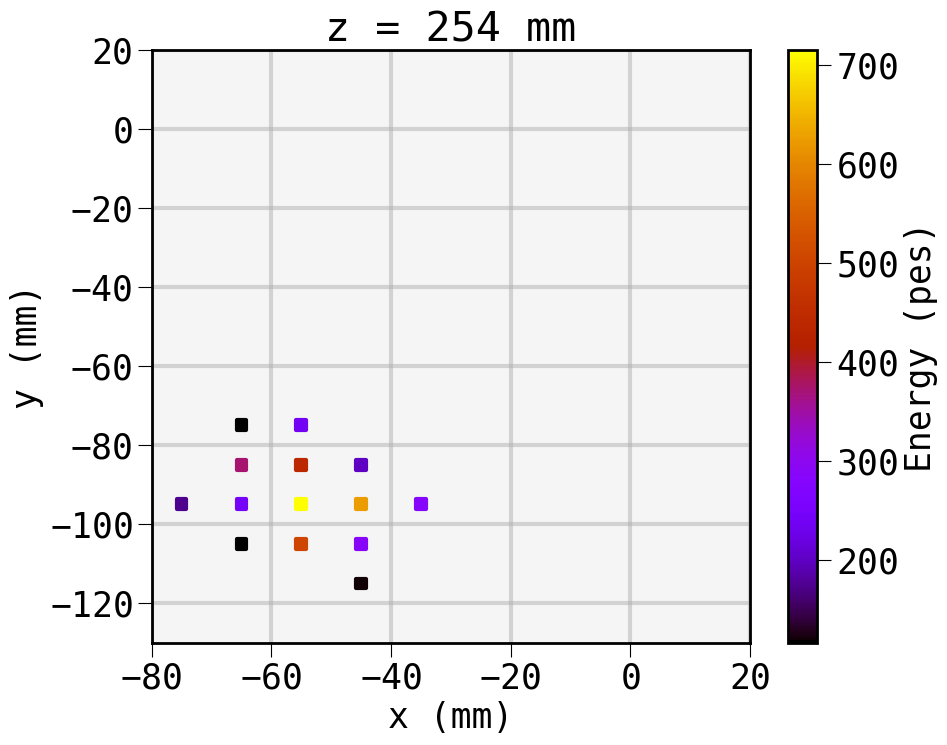

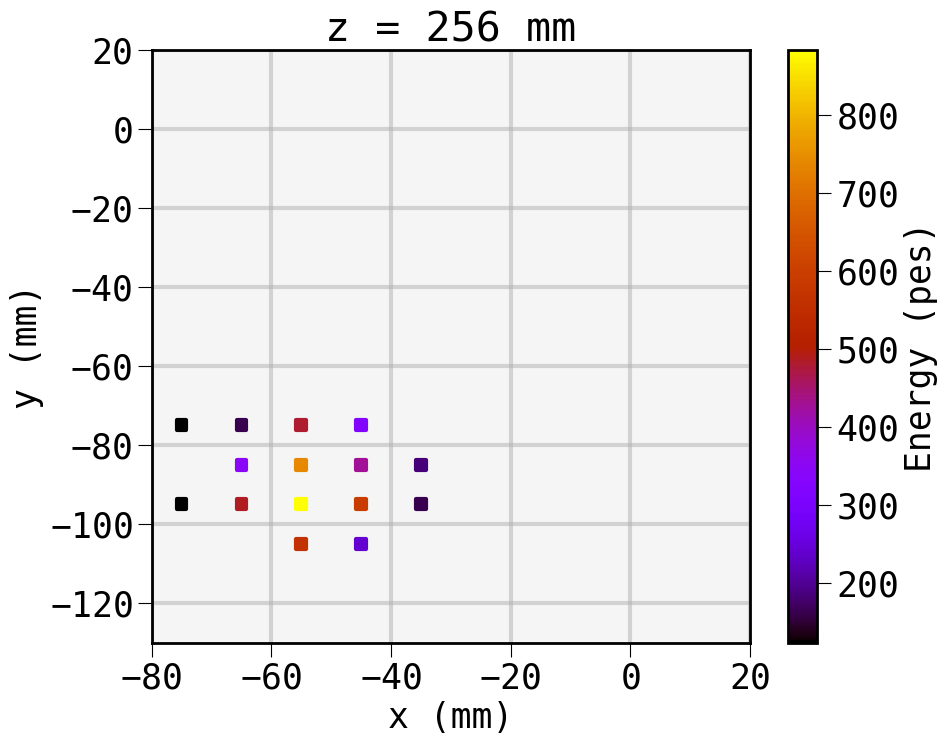

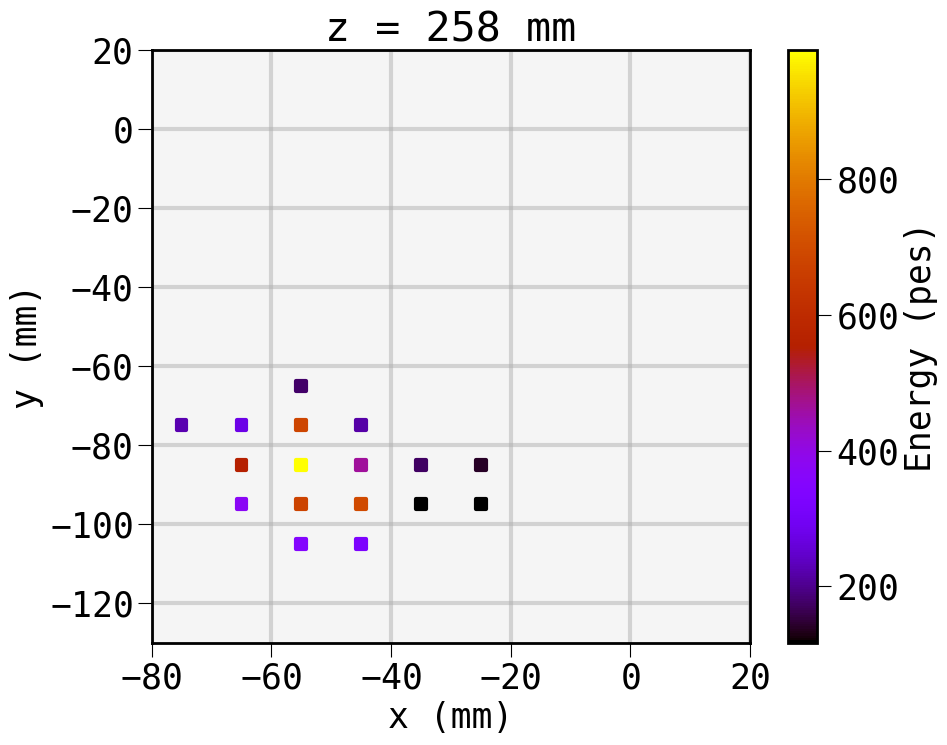

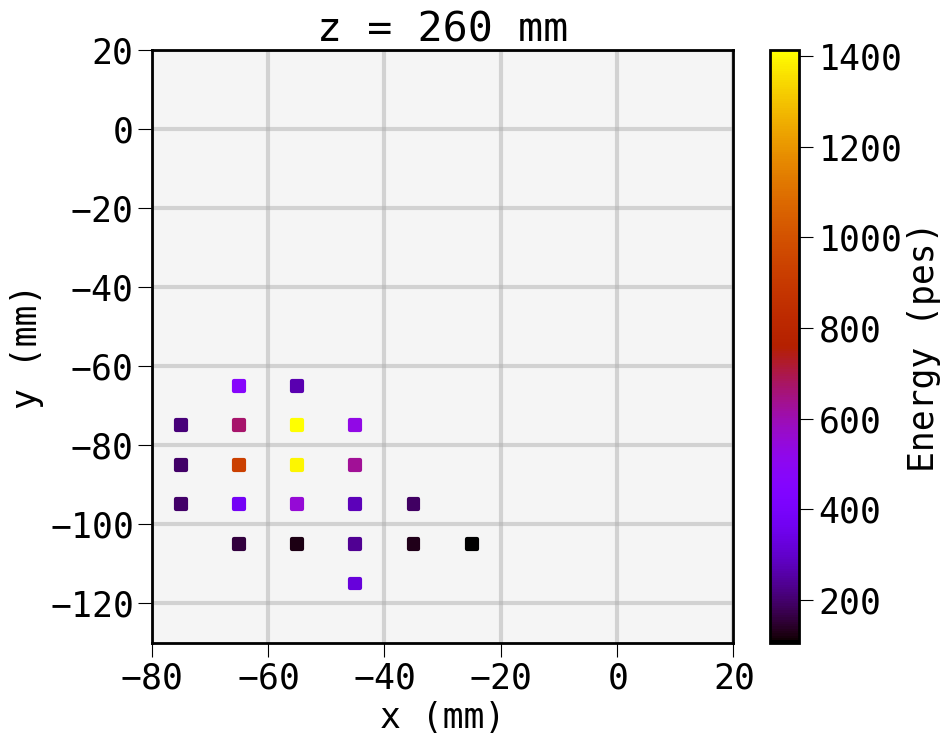

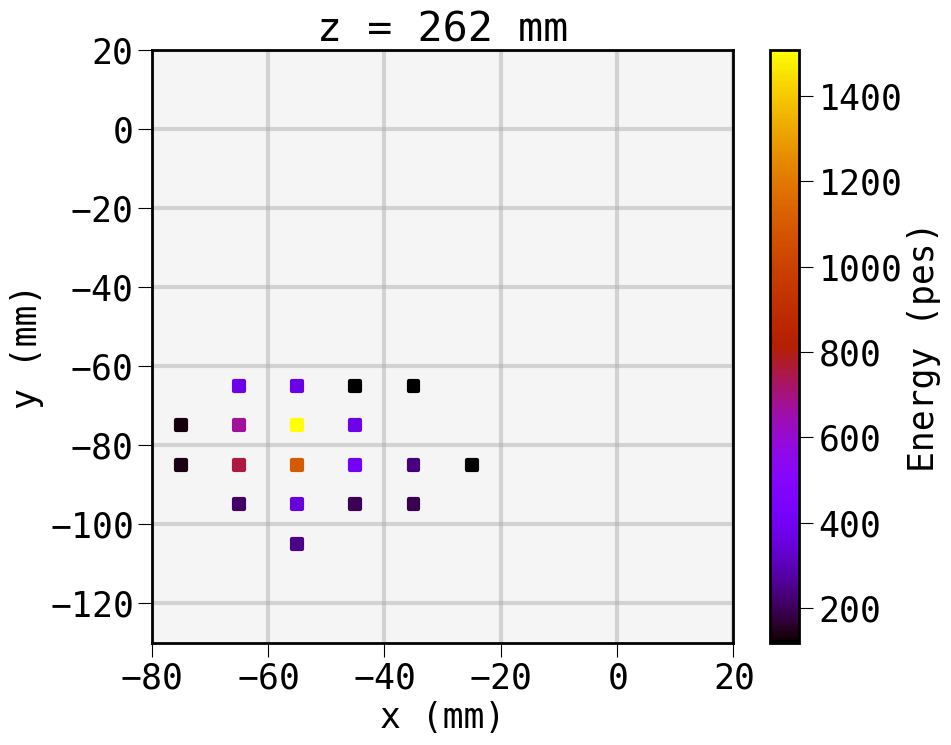

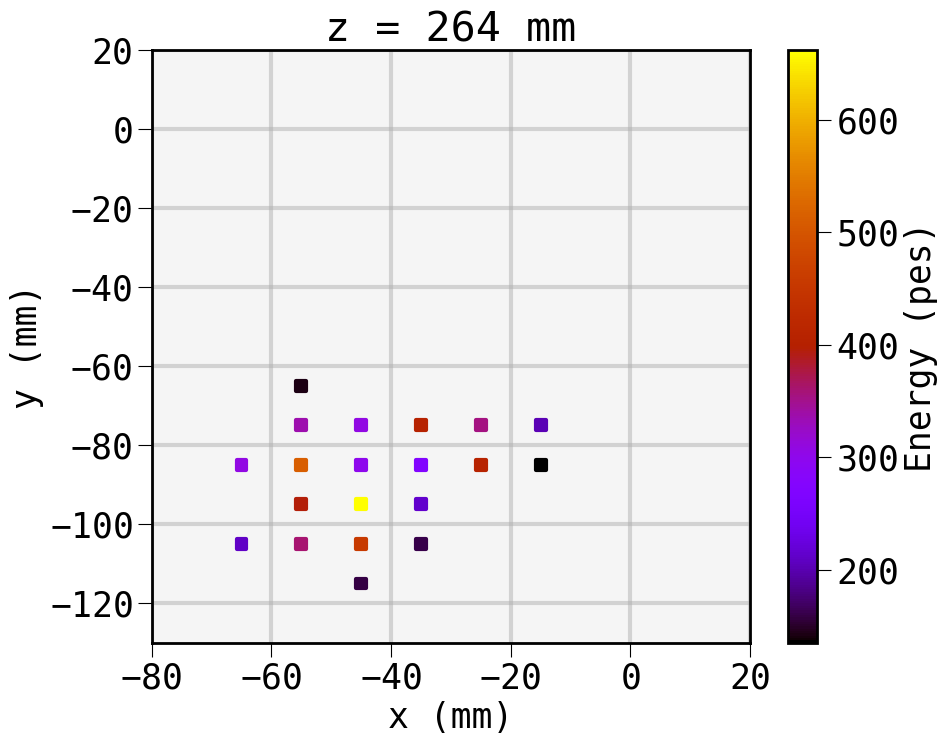

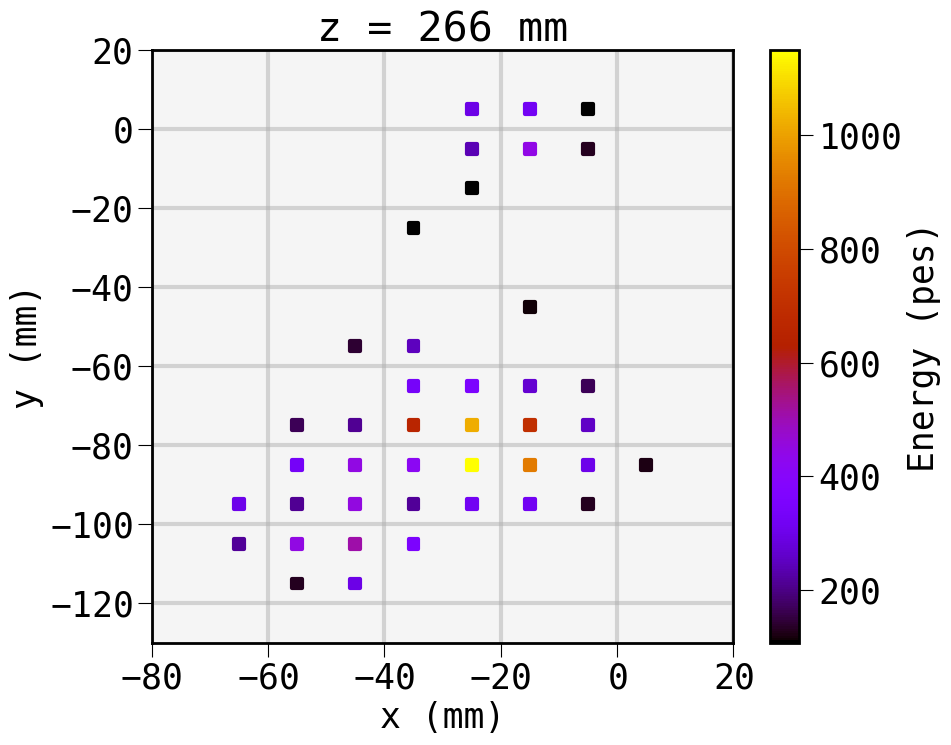

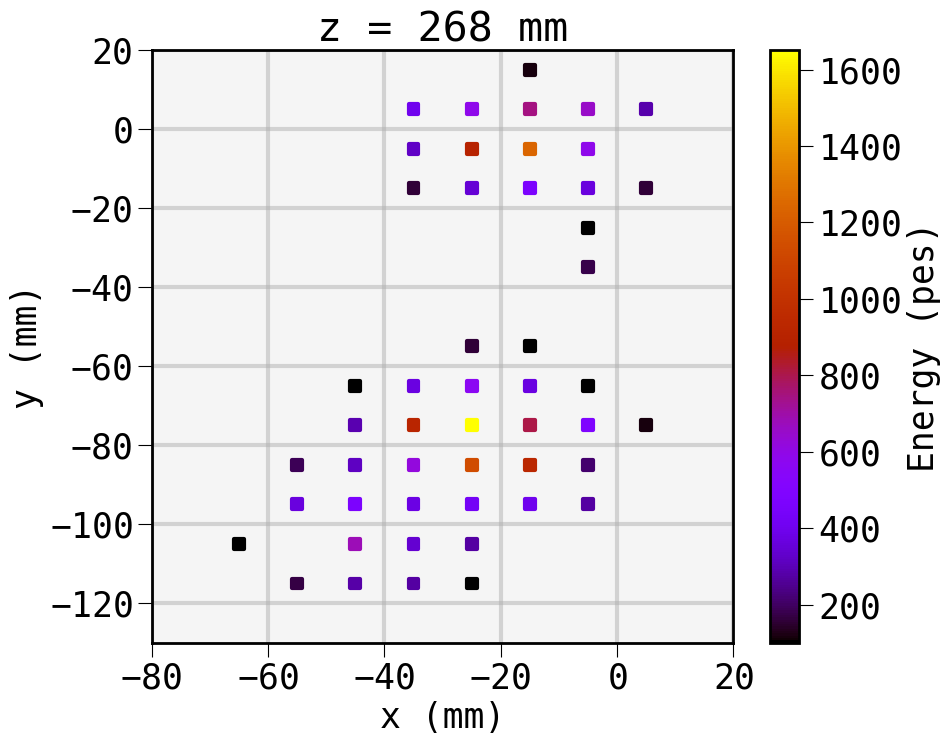

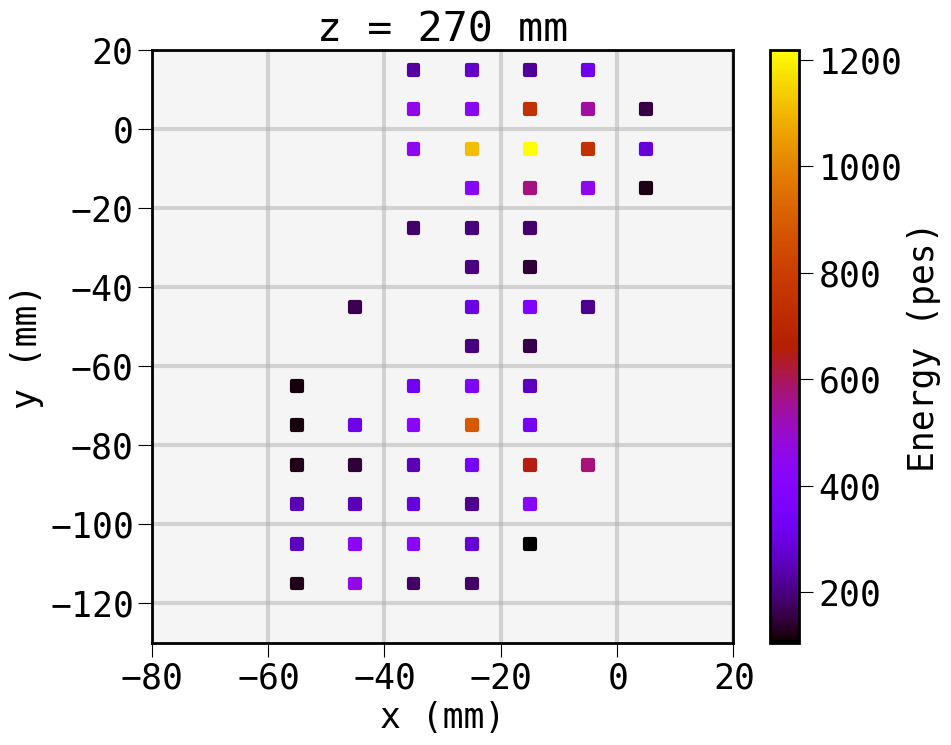

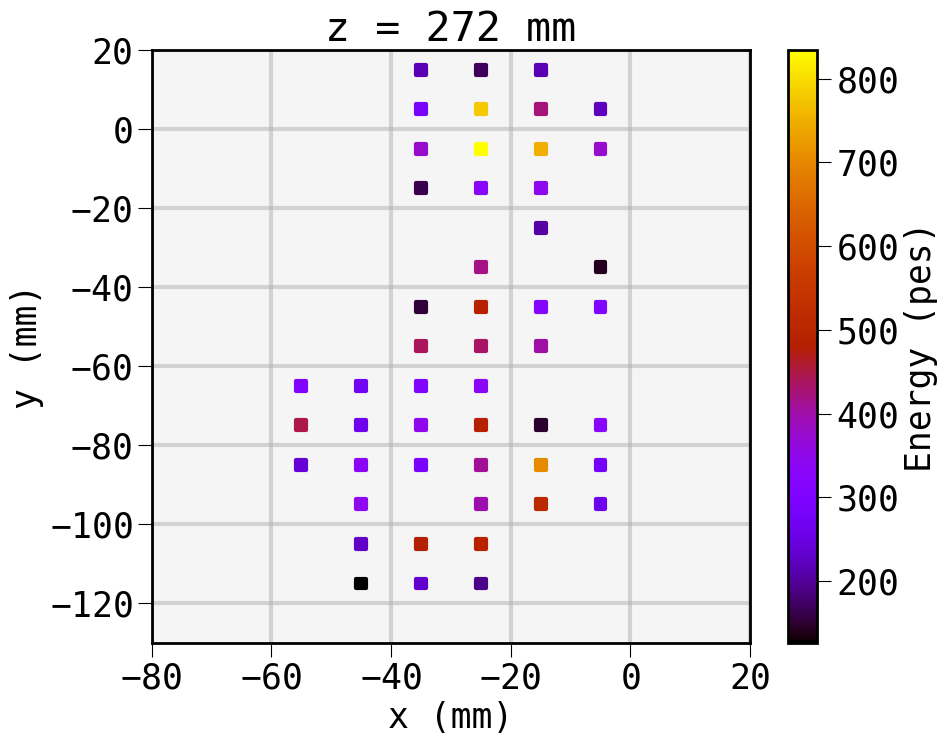

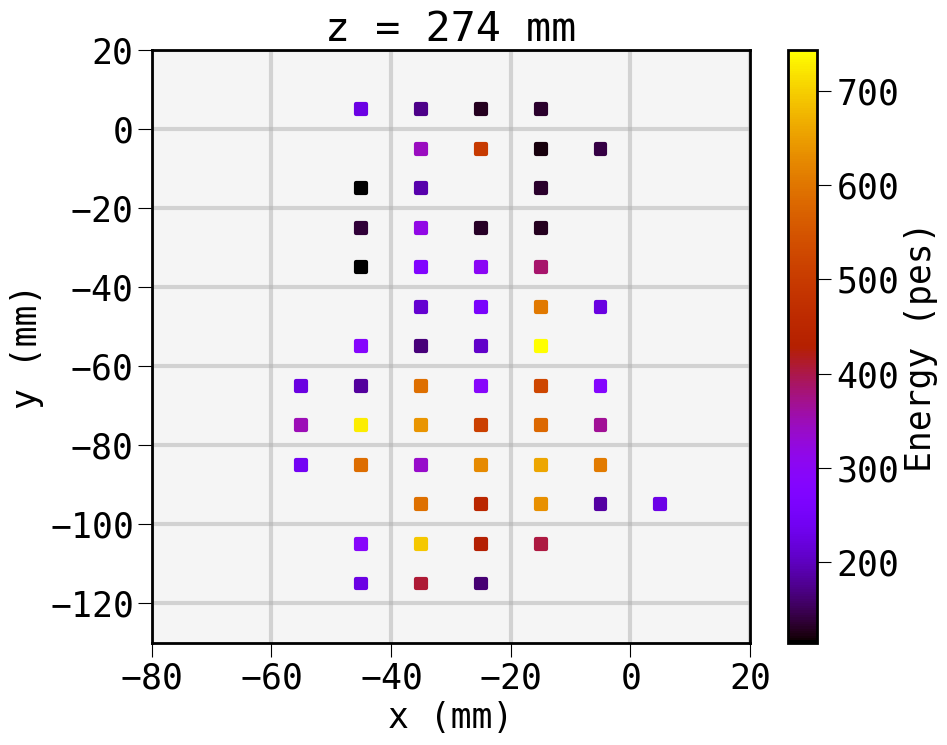

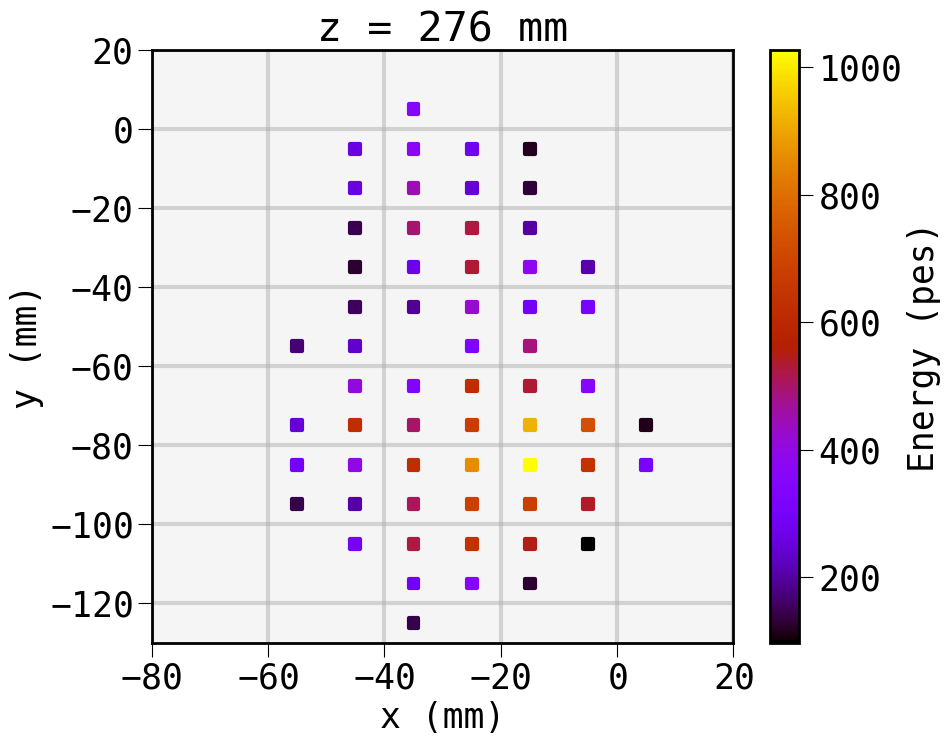

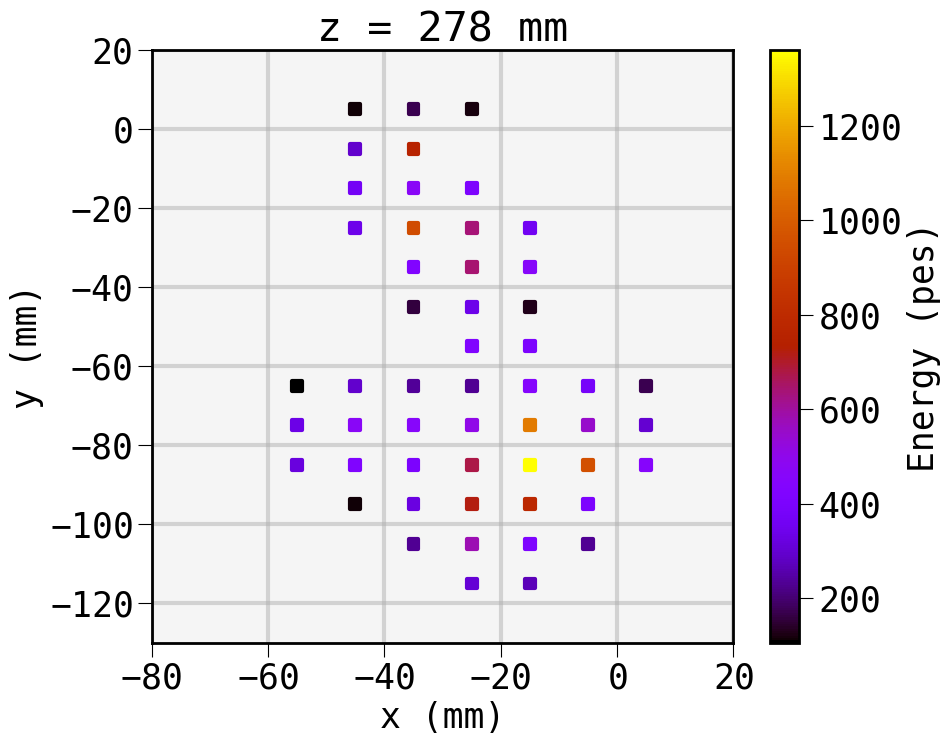

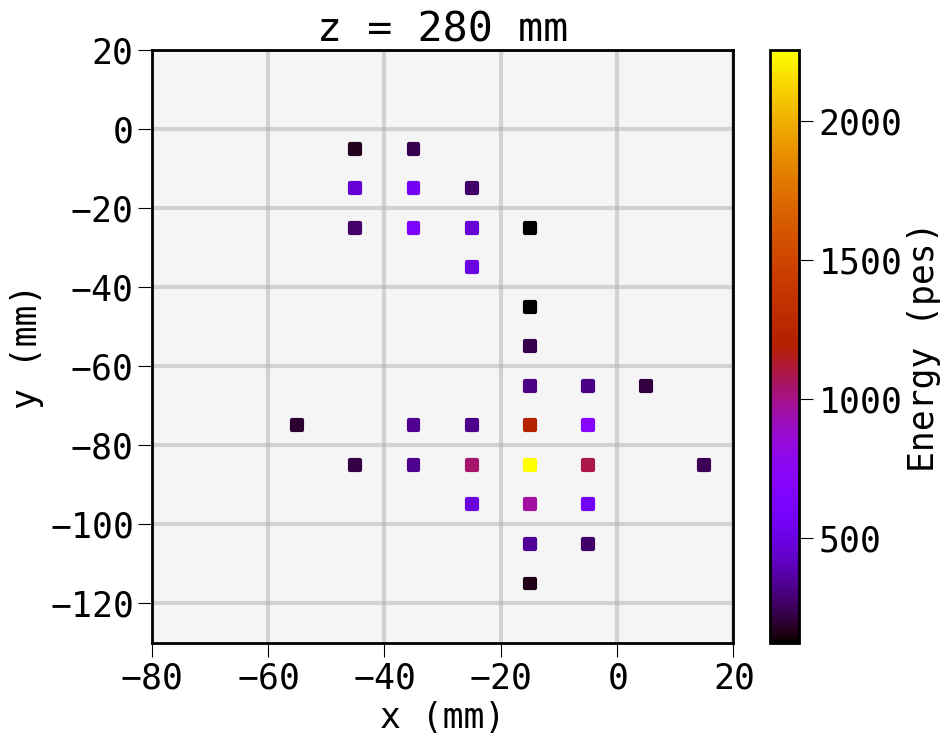

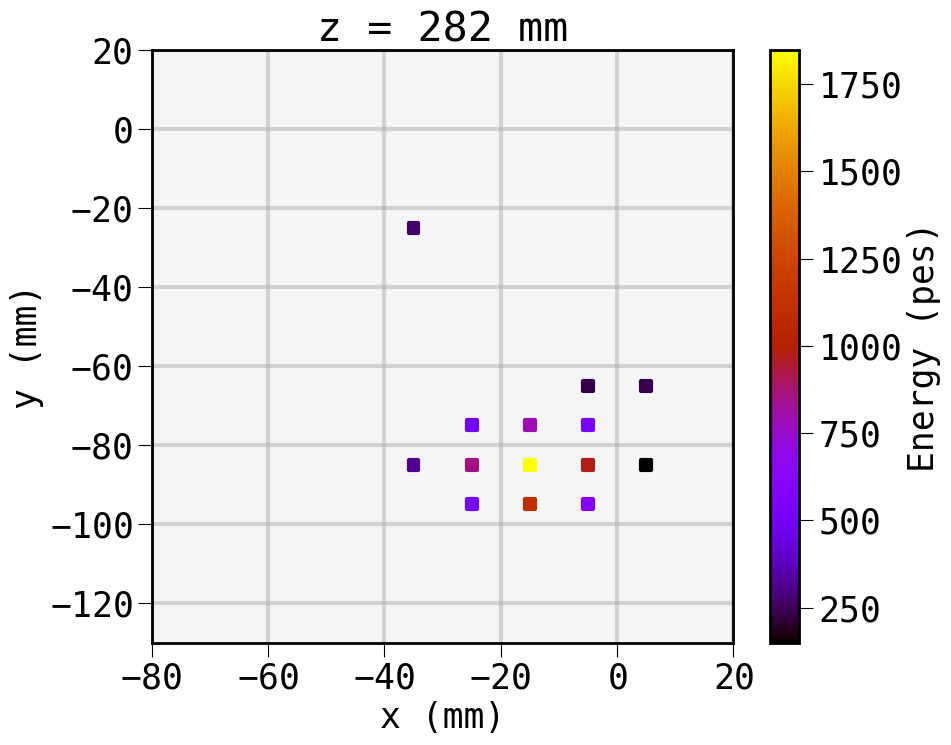

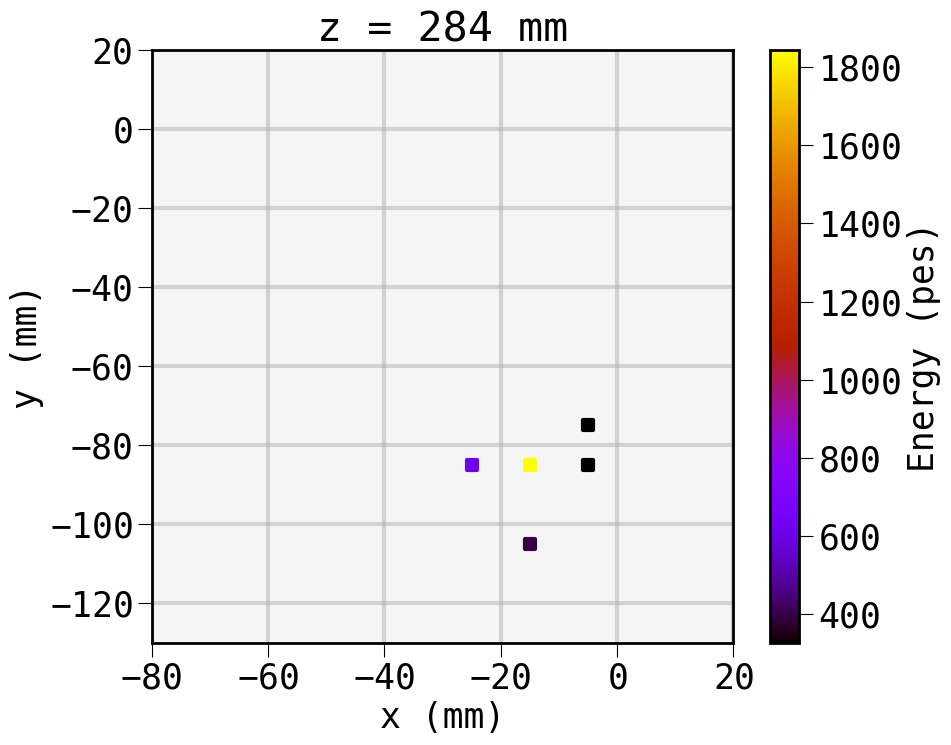

In [15]:
event = dst.event.iloc[0]
peak  = 0
all_hits  = dst.loc[lambda df: (df.event == event) & (df.npeak == peak)]
for z, hits in all_hits.groupby("Z"):
    if len(hits) <= 3: continue
    plt.figure(figsize=(10,8))
    plt.scatter(hits.X, hits.Y, marker="s", s=50, c=hits.E)
    plt.gca().set_facecolor("whitesmoke")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.title(f"z = {z:.0f} mm")
    plt.xlim(all_hits.X.min() - 5, all_hits.X.max() + 5)
    plt.ylim(all_hits.Y.min() - 5, all_hits.Y.max() + 5)
    plt.colorbar().set_label("Energy (pes)")

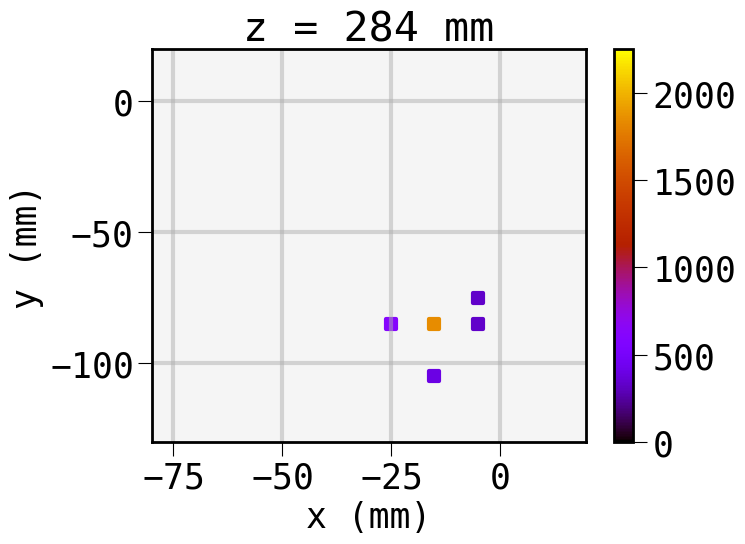

In [16]:
create_hits_animation(all_hits, hitsize=50)

# Notes